<a href="https://colab.research.google.com/github/antonvandike/Algoritmos-Geneticos/blob/main/Programacion%20Gen%C3%A9tica/deap_documentation_gp_symbolic_regression_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Solucion del problema del control de paridad uniforme


In [1]:
pip install deap

###Configuraciones y definiciones

In [2]:
## Paso 1: Modulos

from deap import base
from deap import creator
from deap import tools
from deap import gp
from deap import algorithms

import random as rd
import numpy as np
import math as mt

import operator as op
import sympy as sp

import matplotlib.pyplot as plt
import seaborn as sns

import itertools
import matplotlib.pyplot as plt
import networkx as nx

from functools import partial


In [32]:
## Paso 2: Parametros del problema

# Contenido del problema

POPULATION_SIZE = 100     # Tamaño de la poblacion de individuos
P_CROSSOVER     =  0.9    # Probabilidad de cruza
P_MUTATION      =  0.5    # Probabilidad de mutación

MAX_GENERATIONS = 80   # Maximo numero de generaciones (condición de termino)

In [4]:
HALL_OF_FAME_SIZE = 10

In [5]:
# Constantes especificas de la progrmacion genetica:
MIN_TREE_HEIGHT = 1
MAX_TREE_HEIGHT = 2
LIMIT_TREE_HEIGHT = 17
MUT_MIN_TREE_HEIGHT = 0
MUT_MAX_TREE_HEIGHT = 2

In [6]:
## Paso 3: Elementos aleatorios

RANDOM_SEED = 42          # Comunmente cuando se experimenta con un codigo
rd.seed(RANDOM_SEED)      # se corre el problema con los mismos parametros
                          # para repetir y compara resultados

In [7]:
toolbox = base.Toolbox()

In [8]:
# Define new functions
def protectedDiv(left, right):
    try:
        return left / right
    except ZeroDivisionError:
        return 1

In [9]:
## Paso 4: Declarando el cromosoma

# create the primitive set:
pset = gp.PrimitiveSet("MAIN", 1)

pset.addPrimitive(op.add, 2)
pset.addPrimitive(op.sub, 2)
pset.addPrimitive(op.mul, 2)
pset.addPrimitive(protectedDiv, 2)
pset.addPrimitive(op.neg, 1)
pset.addPrimitive(mt.cos, 1)
pset.addPrimitive(mt.sin, 1)

# add terminal values:

pset.addEphemeralConstant("rand101", partial(rd.randint, -1, 1))
pset.renameArguments(ARG0='x')

toolbox.register("expr", gp.genHalfAndHalf, pset=pset, min_=MIN_TREE_HEIGHT, max_=MAX_TREE_HEIGHT)

In [10]:
## Paso 5: Crear la funcion de aptitud (FITNESS)

# Se indica minimizacion y un solo peso
#creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("FitnessMin", base.Fitness, weights=(-1.0,-0.8,-0.5))


In [11]:
## Paso 6: Crear la funcion de  aptitud del individuo

creator.create("Individual", gp.PrimitiveTree, fitness=creator.FitnessMin)

In [12]:
## Paso 7: Declarar el operador para generador de individuos

toolbox.register("individualCreator", tools.initIterate, creator.Individual, toolbox.expr)

{0: Text(-0.4623630001719894, -1.0, 'cos'),
 1: Text(0.46236300017198956, 0.9999999999999998, '-1')}

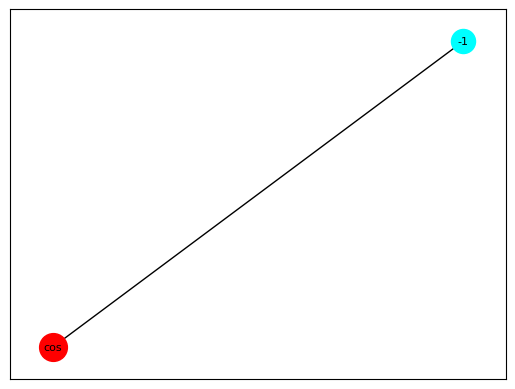

In [13]:
a = toolbox.individualCreator()
nodes, edges, labels = gp.graph(a)
g = nx.Graph()
g.add_nodes_from(nodes)
g.add_edges_from(edges)
pos = nx.spring_layout(g)

nx.draw_networkx_nodes(g, pos, node_color='cyan')
nx.draw_networkx_nodes(g, pos, nodelist=[0], node_color='red', node_size=400)

nx.draw_networkx_edges(g, pos)
nx.draw_networkx_labels(g, pos, **{"labels": labels, "font_size": 8})



In [14]:
#f = lambda x: sp.sin(x)

In [15]:
#print(f(x1))

In [16]:
#print(f(mt.pi/2))

In [17]:
#print(dec)

In [18]:
#x1 = sp.Symbol('x')

In [19]:
#dec(x1)

In [20]:
## Paso 8: Declarar el operador para generar la poblacion

toolbox.register("populationCreator", tools.initRepeat, list, toolbox.individualCreator)

In [21]:
# Crear un operador para compilar el arbol primitivo en el codigo de python

toolbox.register("compile", gp.compile, pset=pset)

In [22]:
## Paso 9: Definir función para calcular la aptitud

def evalSymbReg(individual, points):
    # Transform the tree expression in a callable function
    func = toolbox.compile(expr=individual)
    # Evaluate the mean squared error between the expression
    # and the real function : x**4 + x**3 + x**2 + x
    sqerrors = ((func(x) - x**4 - x**3 - x**2 - x)**2 for x in points)

    a = len(individual)
    b = individual.height

    return mt.fsum(sqerrors) / len(points), a, b,

In [23]:
evalSymbReg(toolbox.individualCreator(), points=[x/10. for x in range(-10,10)])

(1.1938422108085054, 2, 1)

In [24]:
## Paso 10: Declarar el operador de evaluacion

toolbox.register("evaluate", evalSymbReg, points=[x/10. for x in range(-10,10)])

In [25]:
## Paso 11: Declarar los operadores geneticos

toolbox.register("select", tools.selTournament, tournsize=3)
toolbox.register("mate", gp.cxOnePoint)
toolbox.register("expr_mut", gp.genFull, min_=0, max_=2)
toolbox.register("mutate", gp.mutUniform, expr=toolbox.expr_mut, pset=pset)

In [26]:
# bloat control:

toolbox.decorate("mate", gp.staticLimit(key=op.attrgetter("height"), max_value=17))
toolbox.decorate("mutate", gp.staticLimit(key=op.attrgetter("height"), max_value=17))

In [33]:
def symbreg():

    pop = toolbox.populationCreator(POPULATION_SIZE)
    hof = tools.HallOfFame(HALL_OF_FAME_SIZE)

    stats_fit = tools.Statistics(lambda ind: ind.fitness.values)
    stats_size = tools.Statistics(len)

    mstats = tools.MultiStatistics(fitness=stats_fit, size=stats_size)
    mstats.register("avg", np.mean)
    mstats.register("std", np.std)
    mstats.register("min", np.min)
    mstats.register("max", np.max)

    pop, log = algorithms.eaSimple(pop,
                                   toolbox,
                                   cxpb=P_CROSSOVER,
                                   mutpb=P_MUTATION,
                                   ngen=MAX_GENERATIONS,
                                   stats=mstats,
                                   halloffame=hof,
                                   verbose=True)
    # print log
    best = hof.items[0]

    print("-- length={}, height={}".format(len(best), best.height))
    print("-- Best Fitness = ", best.fitness.values[0])


    # plot best tree:
    nodes, edges, labels = gp.graph(best)
    g = nx.Graph()
    g.add_nodes_from(nodes)
    g.add_edges_from(edges)
    pos = nx.spring_layout(g)

    nx.draw_networkx_nodes(g, pos, node_color='cyan')
    nx.draw_networkx_nodes(g, pos, nodelist=[0], node_color='red', node_size=400)

    nx.draw_networkx_edges(g, pos)
    nx.draw_networkx_labels(g, pos, **{"labels": labels, "font_size": 8})
    plt.show()

    print("-- Best Individual = ", best)
    bestSym = toolbox.compile(expr = best)
    print(bestSym)

    x2 = sp.Symbol('x')
    print(bestSym(x2))


   	      	                        fitness                        	                      size                     
   	      	-------------------------------------------------------	-----------------------------------------------
gen	nevals	avg    	gen	max    	min     	nevals	std    	avg 	gen	max	min	nevals	std    
0  	100   	2.49612	0  	18.9739	0.483609	100   	2.08675	3.79	0  	7  	2  	100   	1.55753
1  	94    	2.42799	1  	14.2339	0       	94    	2.03434	4.1 	1  	10 	1  	94    	2.15174
2  	95    	2.33286	2  	14     	0       	95    	2.23691	4.21	2  	14 	1  	95    	2.72872
3  	97    	2.61265	3  	22     	0       	97    	3.34193	4.73	3  	22 	1  	97    	4.08376
4  	96    	2.19195	4  	17     	0       	96    	3.02894	4.08	4  	17 	1  	96    	4.098  
5  	91    	2.78456	5  	24     	0       	91    	3.95443	5.46	5  	24 	1  	91    	5.45054
6  	98    	3.17669	6  	21     	0       	98    	4.16702	6.29	6  	21 	1  	98    	5.54129
7  	95    	3.74744	7  	24     	0       	95    	4.53021	7.5 	7  	24 	1  	95

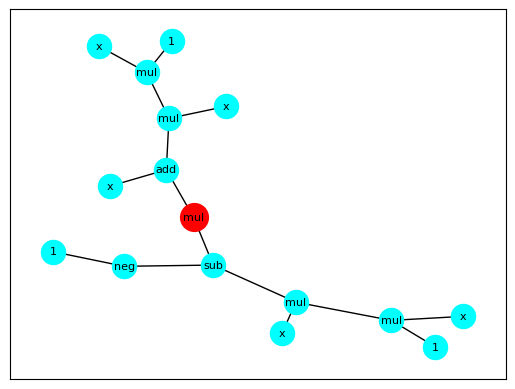

-- Best Individual =  mul(add(mul(x, mul(x, 1)), x), sub(mul(x, mul(1, x)), neg(1)))
<function <lambda> at 0x7e7d85e3ff40>
(x**2 + 1)*(x**2 + x)


In [36]:
symbreg()